In [1]:
import geopandas as gpd
import pandas as pd
import os
import getpass
import matplotlib.pyplot as plt
from earthpy.clip import clip_shp

### NOTES:


###### Bring in necessary geojson files and set your projection for all files

In [2]:
wd = os.getcwd()
wd = wd[:wd.find('notebooks')]

#crs is set for Central Texas; https://epsg.io/6578; 
crs =  {'init' :'epsg:6578'}

#parks = gpd.read_file(wd+"data/coaparks/parkboundaries.geojson")
#parks = parks.to_crs(crs).explode().reset_index()

quartbuff = gpd.read_file(wd+"data/coaparks_buffer/quarterbuff.shp")
quartbuff.crs={'init' :'epsg:6578'}

pop = gpd.read_file(wd+"data/blockgroups_censusdata/popmerge.shp")
pop = pop.to_crs(crs).reset_index()

race = gpd.read_file(wd+"data/blockgroups_censusdata/racemerge.shp")
race = race.to_crs(crs).reset_index()

income = gpd.read_file(wd+"data/blockgroups_censusdata/incomemerge.shp")
income = income.to_crs(crs).reset_index()

##### Check your projections
https://geopandas.org/projections.html

In [3]:
#parks.crs

In [4]:
quartbuff.crs

{'init': 'epsg:6578'}

In [5]:
pop.crs

{'init': 'epsg:6578'}

In [6]:
race.crs

{'init': 'epsg:6578'}

###### Preview the files and clean the data

In [7]:
pop['fullarea_pop'] = pop['geometry'].area
pop.head()

,index,GEOID10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,city_name,jurisdicti,Id,Id2,Total_POP,geometry,fullarea_pop
0,0,482090109011,291268.0,0.0,+30.1776997,-097.9267996,CITY OF AUSTIN,AUSTIN FULL PURPOSE,1500000US482090109011,482090109011,2205,"(POLYGON ((3069238.317597141 10028016.9612432,...",2.280497e+07
1,1,482090109081,142299.0,0.0,+30.0960389,-097.8116716,CITY OF AUSTIN,AUSTIN FULL PURPOSE,1500000US482090109081,482090109081,3774,"POLYGON ((3093548.488136804 10008631.07120929,...",1.837684e+03
2,2,484530001011,17128.0,0.0,+30.3353452,-097.7546582,CITY OF AUSTIN,AUSTIN FULL PURPOSE,1500000US484530001011,484530001011,1045,"POLYGON ((3111310.380106392 10089474.08471978,...",1.023445e+07
3,3,484530001012,43720.0,0.0,+30.3247732,-097.7516364,CITY OF AUSTIN,AUSTIN FULL PURPOSE,1500000US484530001012,484530001012,1202,"POLYGON ((3109356.370562974 10091521.99532213,...",1.190644e+07
4,4,484530001013,415563.0,0.0,+30.3158528,-097.7515898,CITY OF AUSTIN,AUSTIN FULL PURPOSE,1500000US484530001013,484530001013,2016,"POLYGON ((3110878.498096142 10085236.13059729,...",1.151098e+07


In [8]:
race['fullarea_race'] = race['geometry'].area
race.head()

,index,GEOID10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,city_name,jurisdicti,Id,Id2,...,Black or A,American I,Asian; Not,Native Haw,Some other,Two or mor,Hispanic o,Sum of Non,geometry,fullarea_race
0,0,482090109011,291268.0,0.0,+30.1776997,-097.9267996,CITY OF AUSTIN,AUSTIN FULL PURPOSE,1500000US482090109011,482090109011,...,0,0,40,78,0,34,421,2205,"(POLYGON ((3069238.317597141 10028016.9612432,...",2.280497e+07
1,1,482090109081,142299.0,0.0,+30.0960389,-097.8116716,CITY OF AUSTIN,AUSTIN FULL PURPOSE,1500000US482090109081,482090109081,...,91,0,80,0,0,16,2507,3774,"POLYGON ((3093548.488136804 10008631.07120929,...",1.837684e+03
2,2,484530001011,17128.0,0.0,+30.3353452,-097.7546582,CITY OF AUSTIN,AUSTIN FULL PURPOSE,1500000US484530001011,484530001011,...,26,0,0,0,0,20,113,1045,"POLYGON ((3111310.380106392 10089474.08471978,...",1.023445e+07
3,3,484530001012,43720.0,0.0,+30.3247732,-097.7516364,CITY OF AUSTIN,AUSTIN FULL PURPOSE,1500000US484530001012,484530001012,...,0,14,0,0,0,42,121,1202,"POLYGON ((3109356.370562974 10091521.99532213,...",1.190644e+07
4,4,484530001013,415563.0,0.0,+30.3158528,-097.7515898,CITY OF AUSTIN,AUSTIN FULL PURPOSE,1500000US484530001013,484530001013,...,0,0,70,0,0,39,163,2016,"POLYGON ((3110878.498096142 10085236.13059729,...",1.151098e+07


In [9]:
income['fullarea_income'] = income['geometry'].area
income.head()

,index,GEOID10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,city_name,jurisdicti,Id,Id2,...,"$45,000 to","$50,000 to","$60,000 to","$75,000 to","$100,000 t","$125,000 t","$150,000 t","$200,000 o",geometry,fullarea_income
0,0,482090109011,291268.0,0.0,+30.1776997,-097.9267996,CITY OF AUSTIN,AUSTIN FULL PURPOSE,1500000US482090109011,482090109011,...,19,47,51,64,128,42,76,220,"(POLYGON ((3069238.317597141 10028016.9612432,...",2.280497e+07
1,1,482090109081,142299.0,0.0,+30.0960389,-097.8116716,CITY OF AUSTIN,AUSTIN FULL PURPOSE,1500000US482090109081,482090109081,...,123,61,168,215,118,72,84,18,"POLYGON ((3093548.488136804 10008631.07120929,...",1.837684e+03
2,2,484530001011,17128.0,0.0,+30.3353452,-097.7546582,CITY OF AUSTIN,AUSTIN FULL PURPOSE,1500000US484530001011,484530001011,...,5,19,42,56,48,9,71,72,"POLYGON ((3111310.380106392 10089474.08471978,...",1.023445e+07
3,3,484530001012,43720.0,0.0,+30.3247732,-097.7516364,CITY OF AUSTIN,AUSTIN FULL PURPOSE,1500000US484530001012,484530001012,...,6,23,63,15,31,19,92,206,"POLYGON ((3109356.370562974 10091521.99532213,...",1.190644e+07
4,4,484530001013,415563.0,0.0,+30.3158528,-097.7515898,CITY OF AUSTIN,AUSTIN FULL PURPOSE,1500000US484530001013,484530001013,...,15,124,116,94,100,154,101,117,"POLYGON ((3110878.498096142 10085236.13059729,...",1.151098e+07


In [10]:
quartbuff['fullarea_buff'] = quartbuff['geometry'].area
quartbuff.head()

,ASSET_MGMT,LOCATION_N,ADDRESS,CITY_MUNIC,COUNTY,STATE,STREET_NUM,STREET_NAM,STREET_TYP,ZIPCODE,...,MXLOADID,GLOBALID,CREATED_BY,CREATED_DA,MODIFIED_B,MODIFIED_D,Shape__Are,Shape__Len,geometry,fullarea_buff
0,412,Stratford Overlook Greenbelt,"3006 Stratford Dr., Austin, Texas 78746",Austin,Travis,TX,3006,Stratford,Dr.,78746,...,None,None,CTM.Publisher,2019-10-12,CTM.Publisher,2019-10-12,4.403262e+03,420.672106,"POLYGON ((3099659.296639044 10076099.36654302,...",6.701295e+05
1,413,Highland Neighborhood Park,"403 W St Johns Ave., Austin, Texas 78752",Austin,Travis,TX,403,W St Johns,Ave.,78752,...,None,None,CTM.Publisher,2019-10-12,CTM.Publisher,2019-10-12,1.048800e+04,422.279483,"POLYGON ((3122902.889064272 10096179.9084496, ...",6.708336e+05
2,354,Palma Plaza Pocket Park,"1524 Palma Plz., Austin, Texas 78703",Austin,Travis,TX,1524,Palma,Plz,78703,...,None,None,CTM.Publisher,2019-10-12,CTM.Publisher,2019-10-12,1.007678e+04,492.661534,"POLYGON ((3109810.268547321 10075962.94345399,...",6.988492e+05
3,398,Oertli Neighborhood Park,"12613 Blaine Rd., Austin, Texas 78753",Austin,Travis,TX,12613,Blaine,Rd.,78753,...,None,None,CTM.Publisher,2019-10-12,CTM.Publisher,2019-10-12,2.671883e+05,2404.916487,"POLYGON ((3142020.189037629 10117140.78761702,...",1.463807e+06
4,370,Decker Tallgrass Prairie Preserve,"8001 Decker Ln., Austin, Texas 78724",Austin,Travis,TX,8001,Decker,Ln.,78724,...,None,None,CTM.Publisher,2019-10-12,CTM.Publisher,2019-10-12,1.515843e+07,26672.772067,"POLYGON ((3154723.006204365 10083882.87548335,...",9.294015e+06


### Run spatial analysis on the amount of people distributed within a census block group against the quarter mile park buffer area and the race census data

In [11]:
rp_intersection = gpd.overlay(race, quartbuff, how='intersection') #https://geopandas.org/set_operations.html
rp_intersection['area_intersec'] = rp_intersection['geometry'].area
rp_intersection.to_file(wd+"data/access/rp_intersec_quarterbuff_ACS17.shp")
rp_intersection

,index,GEOID10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,city_name,jurisdicti,Id,Id2,...,GLOBALID,CREATED_BY,CREATED_DA,MODIFIED_B,MODIFIED_D,Shape__Are,Shape__Len,fullarea_buff,geometry,area_intersec
2,2,484530001011,17128.0,0.0,+30.3353452,-097.7546582,CITY OF AUSTIN,AUSTIN FULL PURPOSE,1500000US484530001011,484530001011,...,None,CTM.Publisher,2019-10-12,CTM.Publisher,2019-10-12,3.514350e+06,56641.286637,2.083222e+07,(POLYGON ((3112577.691601556 10092106.43546127...,1.937863e+06
7,4,484530001013,415563.0,0.0,+30.3158528,-097.7515898,CITY OF AUSTIN,AUSTIN FULL PURPOSE,1500000US484530001013,484530001013,...,None,CTM.Publisher,2019-10-12,CTM.Publisher,2019-10-12,3.514350e+06,56641.286637,2.083222e+07,"(POLYGON ((3111956.64230204 10087345.37179527,...",1.598405e+06
21,8,484530002041,57831.0,0.0,+30.3027360,-097.7413860,CITY OF AUSTIN,AUSTIN FULL PURPOSE,1500000US484530002041,484530002041,...,None,CTM.Publisher,2019-10-12,CTM.Publisher,2019-10-12,3.514350e+06,56641.286637,2.083222e+07,"POLYGON ((3112579.183619359 10081465.39038167,...",4.060094e+05
24,9,484530002042,16538.0,0.0,+30.3162020,-097.7451126,CITY OF AUSTIN,AUSTIN FULL PURPOSE,1500000US484530002042,484530002042,...,None,CTM.Publisher,2019-10-12,CTM.Publisher,2019-10-12,3.514350e+06,56641.286637,2.083222e+07,(POLYGON ((3112506.819622439 10086223.64617552...,8.211498e+05
30,10,484530002043,61172.0,0.0,+30.3084751,-097.7470902,CITY OF AUSTIN,AUSTIN FULL PURPOSE,1500000US484530002043,484530002043,...,None,CTM.Publisher,2019-10-12,CTM.Publisher,2019-10-12,3.514350e+06,56641.286637,2.083222e+07,"(POLYGON ((3112746.76010764 10081979.97962928,...",1.578661e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1546,542,484910204083,34157.0,0.0,+30.4530947,-097.7811364,CITY OF AUSTIN,AUSTIN FULL PURPOSE,1500000US484910204083,484910204083,...,None,CTM.Publisher,2019-10-12,CTM.Publisher,2019-10-12,5.423833e+05,2970.882179,1.690157e+06,"POLYGON ((3099958.623058978 10137136.64832762,...",1.043275e+05
1544,540,484910204081,9762.0,0.0,+30.4597401,-097.7933842,CITY OF AUSTIN,AUSTIN FULL PURPOSE,1500000US484910204081,484910204081,...,None,CTM.Publisher,2019-10-12,CTM.Publisher,2019-10-12,9.810471e+04,1492.002528,1.070334e+06,"POLYGON ((3100175.699942151 10143570.94554518,...",8.736948e+05
1547,552,484910205081,636722.0,850.0,+30.4840639,-097.7595422,CITY OF AUSTIN,AUSTIN FULL PURPOSE,1500000US484910205081,484910205081,...,None,CTM.Publisher,2019-10-12,CTM.Publisher,2019-10-12,6.289057e+05,3819.975953,1.976420e+06,(POLYGON ((3104261.391998203 10149293.93935596...,1.688160e+05
1551,556,484910205101,2092.0,0.0,+30.4950296,-097.7673875,CITY OF AUSTIN,AUSTIN FULL PURPOSE,1500000US484910205101,484910205101,...,None,CTM.Publisher,2019-10-12,CTM.Publisher,2019-10-12,6.289057e+05,3819.975953,1.976420e+06,"POLYGON ((3105146.529438308 10149196.16067607,...",1.681954e+06


In [12]:
rp_intersection.crs

{'init': 'epsg:6578'}

In [13]:
rp_intersection.columns

Index(['index', 'GEOID10', 'ALAND10', 'AWATER10', 'INTPTLAT10', 'INTPTLON10',
       'city_name', 'jurisdicti', 'Id', 'Id2', 'Total_POP', 'Not Hispan',
       'White; Not', 'Black or A', 'American I', 'Asian; Not', 'Native Haw',
       'Some other', 'Two or mor', 'Hispanic o', 'Sum of Non', 'fullarea_race',
       'ASSET_MGMT', 'LOCATION_N', 'ADDRESS', 'CITY_MUNIC', 'COUNTY', 'STATE',
       'STREET_NUM', 'STREET_NAM', 'STREET_TYP', 'ZIPCODE', 'ASSET_SIZE',
       'ACRE_SOURC', 'UNIT_OF_ME', 'YEAR_ACQUI', 'ASSET_STAT', 'DEVELOPMEN',
       'TPL_LANDUS', 'PARK_TYPE', 'LEVEL_OF_S', 'LEVEL_OF_U', 'SERVICE_AR',
       'COUNCIL_DI', 'COUNCIL__1', 'MANAGEMENT', 'OWNER_NAME', 'OWNER_TYPE',
       'MANAGING_N', 'MANAGING_T', 'ACQUISITIO', 'ACQUISIT_1', 'ACQUISIT_2',
       'DEVELOPM_1', 'DEVELOPM_2', 'RESTRICTIO', 'LWCF_PROTE', 'OTHER_PROT',
       'REST_PROT_', 'COMMUNITY_', 'MXASSETNUM', 'MXLOCATION', 'MXSITEID',
       'MXCREATION', 'MXSTATUS', 'MXCONDITIO', 'MXPRIORITY', 'MXLOADID',
      

In [14]:
rp_intersection[['GEOID10','Total_POP','fullarea_race','LOCATION_N','fullarea_buff','area_intersec','geometry']]

,GEOID10,Total_POP,fullarea_race,LOCATION_N,fullarea_buff,area_intersec,geometry
2,484530001011,1045,1.023445e+07,Shoal Creek Greenbelt,2.083222e+07,1.937863e+06,(POLYGON ((3112577.691601556 10092106.43546127...
7,484530001013,2016,1.151098e+07,Shoal Creek Greenbelt,2.083222e+07,1.598405e+06,"(POLYGON ((3111956.64230204 10087345.37179527,..."
21,484530002041,1113,5.533474e+06,Shoal Creek Greenbelt,2.083222e+07,4.060094e+05,"POLYGON ((3112579.183619359 10081465.39038167,..."
24,484530002042,1255,5.936942e+06,Shoal Creek Greenbelt,2.083222e+07,8.211498e+05,(POLYGON ((3112506.819622439 10086223.64617552...
30,484530002043,692,8.170845e+06,Shoal Creek Greenbelt,2.083222e+07,1.578661e+06,"(POLYGON ((3112746.76010764 10081979.97962928,..."
...,...,...,...,...,...,...,...
1546,484910204083,835,9.487768e+05,Springwoods Neighborhood Park,1.690157e+06,1.043275e+05,"POLYGON ((3099958.623058978 10137136.64832762,..."
1544,484910204081,1797,1.660166e+07,Forest North Neighborhood Park,1.070334e+06,8.736948e+05,"POLYGON ((3100175.699942151 10143570.94554518,..."
1547,484910205081,3775,3.682212e+07,Davis Spring Special Park,1.976420e+06,1.688160e+05,(POLYGON ((3104261.391998203 10149293.93935596...
1551,484910205101,4695,3.462268e+07,Davis Spring Special Park,1.976420e+06,1.681954e+06,"POLYGON ((3105146.529438308 10149196.16067607,..."


In [15]:
race_clip=rp_intersection.copy().reset_index()

for val in race_clip:

    race_clip['weight'] = race_clip['area_intersec']/ race_clip['fullarea_race']
    
    race_clip['access_pop'] = race_clip['weight'] * race_clip['Total_POP']
    race_clip['access_nonhis'] = race_clip['weight'] * race_clip['Not Hispan']
    race_clip['access_white'] = race_clip['weight'] * race_clip['White; Not']
    race_clip['access_his_lat'] = race_clip['weight'] * race_clip['Hispanic o']

race_clip.head()

,level_0,index,GEOID10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,city_name,jurisdicti,Id,...,Shape__Are,Shape__Len,fullarea_buff,geometry,area_intersec,weight,access_pop,access_nonhis,access_white,access_his_lat
0,2,2,484530001011,17128.0,0.0,+30.3353452,-097.7546582,CITY OF AUSTIN,AUSTIN FULL PURPOSE,1500000US484530001011,...,3.514350e+06,56641.286637,2.083222e+07,(POLYGON ((3112577.691601556 10092106.43546127...,1.937863e+06,0.189347,197.867768,176.471541,167.761572,21.396228
1,7,4,484530001013,415563.0,0.0,+30.3158528,-097.7515898,CITY OF AUSTIN,AUSTIN FULL PURPOSE,1500000US484530001013,...,3.514350e+06,56641.286637,2.083222e+07,"(POLYGON ((3111956.64230204 10087345.37179527,...",1.598405e+06,0.138859,279.940023,257.305983,242.170337,22.634040
2,21,8,484530002041,57831.0,0.0,+30.3027360,-097.7413860,CITY OF AUSTIN,AUSTIN FULL PURPOSE,1500000US484530002041,...,3.514350e+06,56641.286637,2.083222e+07,"POLYGON ((3112579.183619359 10081465.39038167,...",4.060094e+05,0.073373,81.664523,70.071536,59.359029,11.592987
3,24,9,484530002042,16538.0,0.0,+30.3162020,-097.7451126,CITY OF AUSTIN,AUSTIN FULL PURPOSE,1500000US484530002042,...,3.514350e+06,56641.286637,2.083222e+07,(POLYGON ((3112506.819622439 10086223.64617552...,8.211498e+05,0.138312,173.581460,152.419736,138.450232,21.161724
4,30,10,484530002043,61172.0,0.0,+30.3084751,-097.7470902,CITY OF AUSTIN,AUSTIN FULL PURPOSE,1500000US484530002043,...,3.514350e+06,56641.286637,2.083222e+07,"(POLYGON ((3112746.76010764 10081979.97962928,...",1.578661e+06,0.193207,133.698975,109.354942,92.159554,24.344033


In [16]:
race_clip.columns

Index(['level_0', 'index', 'GEOID10', 'ALAND10', 'AWATER10', 'INTPTLAT10',
       'INTPTLON10', 'city_name', 'jurisdicti', 'Id', 'Id2', 'Total_POP',
       'Not Hispan', 'White; Not', 'Black or A', 'American I', 'Asian; Not',
       'Native Haw', 'Some other', 'Two or mor', 'Hispanic o', 'Sum of Non',
       'fullarea_race', 'ASSET_MGMT', 'LOCATION_N', 'ADDRESS', 'CITY_MUNIC',
       'COUNTY', 'STATE', 'STREET_NUM', 'STREET_NAM', 'STREET_TYP', 'ZIPCODE',
       'ASSET_SIZE', 'ACRE_SOURC', 'UNIT_OF_ME', 'YEAR_ACQUI', 'ASSET_STAT',
       'DEVELOPMEN', 'TPL_LANDUS', 'PARK_TYPE', 'LEVEL_OF_S', 'LEVEL_OF_U',
       'SERVICE_AR', 'COUNCIL_DI', 'COUNCIL__1', 'MANAGEMENT', 'OWNER_NAME',
       'OWNER_TYPE', 'MANAGING_N', 'MANAGING_T', 'ACQUISITIO', 'ACQUISIT_1',
       'ACQUISIT_2', 'DEVELOPM_1', 'DEVELOPM_2', 'RESTRICTIO', 'LWCF_PROTE',
       'OTHER_PROT', 'REST_PROT_', 'COMMUNITY_', 'MXASSETNUM', 'MXLOCATION',
       'MXSITEID', 'MXCREATION', 'MXSTATUS', 'MXCONDITIO', 'MXPRIORITY',
       

In [17]:
race_calc = race_clip[['LOCATION_N', 'access_pop', 'access_nonhis','access_white', 'access_his_lat','geometry']]

access_data = race_calc.dissolve(by='LOCATION_N',as_index=False, aggfunc='sum')
access_data.to_file(wd+"data/access/access_data_race_ACS17.shp")
access_data

,LOCATION_N,geometry,access_pop,access_nonhis,access_white,access_his_lat
0,A.B. Dittmar Neighborhood Park,"POLYGON ((3097020.310937755 10040423.29635413,...",247.977755,162.079414,128.683162,85.898341
1,Adams-Hemphill Neighborhood Park,"POLYGON ((3115850.357792675 10080502.90460191,...",1354.176164,1170.820941,935.254003,183.355223
2,Agave Neighborhood Park,"POLYGON ((3144770.981680033 10080963.49225345,...",335.671533,54.503339,31.352479,281.168194
3,Alamo Pocket Park,"POLYGON ((3121188.167724669 10076733.3592437, ...",115.493875,105.121175,59.412007,10.372700
4,Alderbrook Pocket Park,"POLYGON ((3127839.866424789 10124813.31840664,...",351.309776,247.539393,206.342036,103.770383
...,...,...,...,...,...,...
285,Wunneburger Neighborhood Park,(POLYGON ((3095156.226719216 10021252.69393206...,1.153109,0.701316,0.596572,0.451794
286,Yates Pocket Park,"POLYGON ((3128393.558881322 10059201.38858544,...",181.522781,77.983533,24.206194,103.539248
287,Yett Creek Neighborhood Park,"POLYGON ((3117185.845495133 10129921.9187002, ...",164.411123,147.521425,138.145237,16.889699
288,Zilker Metro Park,"(POLYGON ((3105748.96466563 10067644.87424662,...",664.774783,608.525777,543.164192,56.249006


In [18]:
access_data.crs

{'init': 'epsg:6578'}

In [19]:
access_data.columns

Index(['LOCATION_N', 'geometry', 'access_pop', 'access_nonhis', 'access_white',
       'access_his_lat'],
      dtype='object')

#### A dataframe is created with the 'acess_data' geoshapefile. This dataframe is cleaned up and the values are convereted into integers. Finally, we export the dataframe into a csv file and a shapefile. 

In [54]:
df = pd.DataFrame(access_data)
df['Park_Name']=df['LOCATION_N']
df['Total_Pop'] = df['access_pop'].astype(int)
df['Non_Hispan'] = df['access_nonhis'].astype(int)
df['White'] = df['access_white'].astype(int)
df['Hispan_Latin'] = df['access_his_lat'].astype(int)

df.head()


,LOCATION_N,geometry,access_pop,access_nonhis,access_white,access_his_lat,Park_Name,Total_Pop,Non_Hispan,White,Hispan_Latin
0,A.B. Dittmar Neighborhood Park,"POLYGON ((3097020.310937755 10040423.29635413,...",247.977755,162.079414,128.683162,85.898341,A.B. Dittmar Neighborhood Park,247,162,128,85
1,Adams-Hemphill Neighborhood Park,"POLYGON ((3115850.357792675 10080502.90460191,...",1354.176164,1170.820941,935.254003,183.355223,Adams-Hemphill Neighborhood Park,1354,1170,935,183
2,Agave Neighborhood Park,"POLYGON ((3144770.981680033 10080963.49225345,...",335.671533,54.503339,31.352479,281.168194,Agave Neighborhood Park,335,54,31,281
3,Alamo Pocket Park,"POLYGON ((3121188.167724669 10076733.3592437, ...",115.493875,105.121175,59.412007,10.372700,Alamo Pocket Park,115,105,59,10
4,Alderbrook Pocket Park,"POLYGON ((3127839.866424789 10124813.31840664,...",351.309776,247.539393,206.342036,103.770383,Alderbrook Pocket Park,351,247,206,103


In [ ]:
access_race_final = df.drop(columns=['LOCATION_N','access_pop','access_nonhis','access_white','access_his_lat'])
access_race_final = gpd.GeoDataFrame(access_race_final, geometry='geometry')
access_race_final.to_file(wd+"data/access/access_race_final_ACS17.shp")
access_race_final.head()

In [ ]:
access_racetable = df.(columns=['Park_Name','Total_Pop','Non_Hispan','Hipan_Latin','White'])
access_racetable.to_csv(wd+"data/access/access_table_race_ACS17.csv")
access_racetable.head()

,geometry,Park_Name,Total_Pop,Non_Hispan,White,Hispan_Latin
0,"POLYGON ((3097020.310937755 10040423.29635413,...",A.B. Dittmar Neighborhood Park,247,162,128,85
1,"POLYGON ((3115850.357792675 10080502.90460191,...",Adams-Hemphill Neighborhood Park,1354,1170,935,183
2,"POLYGON ((3144770.981680033 10080963.49225345,...",Agave Neighborhood Park,335,54,31,281
3,"POLYGON ((3121188.167724669 10076733.3592437, ...",Alamo Pocket Park,115,105,59,10
4,"POLYGON ((3127839.866424789 10124813.31840664,...",Alderbrook Pocket Park,351,247,206,103


,Park_Name,Total_Pop,Non_Hispan,White,Hispan_Latin
0,A.B. Dittmar Neighborhood Park,247,162,128,85
1,Adams-Hemphill Neighborhood Park,1354,1170,935,183
2,Agave Neighborhood Park,335,54,31,281
3,Alamo Pocket Park,115,105,59,10
4,Alderbrook Pocket Park,351,247,206,103


In [43]:
access_racetable.describe()

,Total_Pop,Non_Hispan,White,Hispan_Latin
count,290.000000,290.000000,290.000000,290.000000
mean,426.813793,277.203448,208.313793,149.103448
std,600.459380,417.814900,322.174244,266.562008
min,0.000000,0.000000,0.000000,0.000000
25%,164.000000,99.250000,63.250000,21.250000
50%,245.500000,158.000000,123.500000,68.500000
75%,447.000000,256.500000,200.750000,159.000000
max,5414.000000,4028.000000,3239.000000,2741.000000


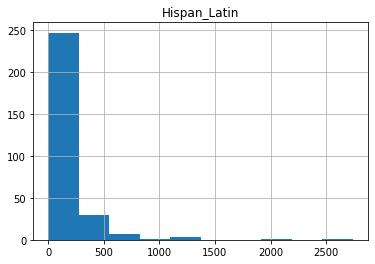

In [45]:
access_racetable.hist('Hispan_Latin');

### Run spatial analysis on the amount of people distributed within a census block group against the quarter mile park buffer area and the income census data

In [24]:
ip_intersection = gpd.overlay(income, quartbuff, how='intersection') #https://geopandas.org/set_operations.html
ip_intersection['iarea_intersec'] = ip_intersection['geometry'].area
ip_intersection.to_file(wd+"data/access/ip_intersec_quarterbuff_ACS17.shp")
ip_intersection

,index,GEOID10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,city_name,jurisdicti,Id,Id2,...,GLOBALID,CREATED_BY,CREATED_DA,MODIFIED_B,MODIFIED_D,Shape__Are,Shape__Len,fullarea_buff,geometry,iarea_intersec
2,2,484530001011,17128.0,0.0,+30.3353452,-097.7546582,CITY OF AUSTIN,AUSTIN FULL PURPOSE,1500000US484530001011,484530001011,...,None,CTM.Publisher,2019-10-12,CTM.Publisher,2019-10-12,3.514350e+06,56641.286637,2.083222e+07,(POLYGON ((3112577.691601556 10092106.43546127...,1.937863e+06
7,4,484530001013,415563.0,0.0,+30.3158528,-097.7515898,CITY OF AUSTIN,AUSTIN FULL PURPOSE,1500000US484530001013,484530001013,...,None,CTM.Publisher,2019-10-12,CTM.Publisher,2019-10-12,3.514350e+06,56641.286637,2.083222e+07,"(POLYGON ((3111956.64230204 10087345.37179527,...",1.598405e+06
21,8,484530002041,57831.0,0.0,+30.3027360,-097.7413860,CITY OF AUSTIN,AUSTIN FULL PURPOSE,1500000US484530002041,484530002041,...,None,CTM.Publisher,2019-10-12,CTM.Publisher,2019-10-12,3.514350e+06,56641.286637,2.083222e+07,"POLYGON ((3112579.183619359 10081465.39038167,...",4.060094e+05
24,9,484530002042,16538.0,0.0,+30.3162020,-097.7451126,CITY OF AUSTIN,AUSTIN FULL PURPOSE,1500000US484530002042,484530002042,...,None,CTM.Publisher,2019-10-12,CTM.Publisher,2019-10-12,3.514350e+06,56641.286637,2.083222e+07,(POLYGON ((3112506.819622439 10086223.64617552...,8.211498e+05
30,10,484530002043,61172.0,0.0,+30.3084751,-097.7470902,CITY OF AUSTIN,AUSTIN FULL PURPOSE,1500000US484530002043,484530002043,...,None,CTM.Publisher,2019-10-12,CTM.Publisher,2019-10-12,3.514350e+06,56641.286637,2.083222e+07,"(POLYGON ((3112746.76010764 10081979.97962928,...",1.578661e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1546,542,484910204083,34157.0,0.0,+30.4530947,-097.7811364,CITY OF AUSTIN,AUSTIN FULL PURPOSE,1500000US484910204083,484910204083,...,None,CTM.Publisher,2019-10-12,CTM.Publisher,2019-10-12,5.423833e+05,2970.882179,1.690157e+06,"POLYGON ((3099958.623058978 10137136.64832762,...",1.043275e+05
1544,540,484910204081,9762.0,0.0,+30.4597401,-097.7933842,CITY OF AUSTIN,AUSTIN FULL PURPOSE,1500000US484910204081,484910204081,...,None,CTM.Publisher,2019-10-12,CTM.Publisher,2019-10-12,9.810471e+04,1492.002528,1.070334e+06,"POLYGON ((3100175.699942151 10143570.94554518,...",8.736948e+05
1547,552,484910205081,636722.0,850.0,+30.4840639,-097.7595422,CITY OF AUSTIN,AUSTIN FULL PURPOSE,1500000US484910205081,484910205081,...,None,CTM.Publisher,2019-10-12,CTM.Publisher,2019-10-12,6.289057e+05,3819.975953,1.976420e+06,(POLYGON ((3104261.391998203 10149293.93935596...,1.688160e+05
1551,556,484910205101,2092.0,0.0,+30.4950296,-097.7673875,CITY OF AUSTIN,AUSTIN FULL PURPOSE,1500000US484910205101,484910205101,...,None,CTM.Publisher,2019-10-12,CTM.Publisher,2019-10-12,6.289057e+05,3819.975953,1.976420e+06,"POLYGON ((3105146.529438308 10149196.16067607,...",1.681954e+06


In [25]:
ip_intersection.columns

Index(['index', 'GEOID10', 'ALAND10', 'AWATER10', 'INTPTLAT10', 'INTPTLON10',
       'city_name', 'jurisdicti', 'Id', 'Id2', 'Total_Pop', 'Less than',
       '$10,000 to', '$15,000 to', '$20,000 to', '$25,000 to', '$30,000 to',
       '$35,000 to', '$40,000 to', '$45,000 to', '$50,000 to', '$60,000 to',
       '$75,000 to', '$100,000 t', '$125,000 t', '$150,000 t', '$200,000 o',
       'fullarea_income', 'ASSET_MGMT', 'LOCATION_N', 'ADDRESS', 'CITY_MUNIC',
       'COUNTY', 'STATE', 'STREET_NUM', 'STREET_NAM', 'STREET_TYP', 'ZIPCODE',
       'ASSET_SIZE', 'ACRE_SOURC', 'UNIT_OF_ME', 'YEAR_ACQUI', 'ASSET_STAT',
       'DEVELOPMEN', 'TPL_LANDUS', 'PARK_TYPE', 'LEVEL_OF_S', 'LEVEL_OF_U',
       'SERVICE_AR', 'COUNCIL_DI', 'COUNCIL__1', 'MANAGEMENT', 'OWNER_NAME',
       'OWNER_TYPE', 'MANAGING_N', 'MANAGING_T', 'ACQUISITIO', 'ACQUISIT_1',
       'ACQUISIT_2', 'DEVELOPM_1', 'DEVELOPM_2', 'RESTRICTIO', 'LWCF_PROTE',
       'OTHER_PROT', 'REST_PROT_', 'COMMUNITY_', 'MXASSETNUM', 'MXLOCATION',

In [26]:
ip_intersection[['GEOID10','Total_Pop','fullarea_income','LOCATION_N','fullarea_buff','iarea_intersec','geometry']]

,GEOID10,Total_Pop,fullarea_income,LOCATION_N,fullarea_buff,iarea_intersec,geometry
2,484530001011,396,1.023445e+07,Shoal Creek Greenbelt,2.083222e+07,1.937863e+06,(POLYGON ((3112577.691601556 10092106.43546127...
7,484530001013,1154,1.151098e+07,Shoal Creek Greenbelt,2.083222e+07,1.598405e+06,"(POLYGON ((3111956.64230204 10087345.37179527,..."
21,484530002041,604,5.533474e+06,Shoal Creek Greenbelt,2.083222e+07,4.060094e+05,"POLYGON ((3112579.183619359 10081465.39038167,..."
24,484530002042,635,5.936942e+06,Shoal Creek Greenbelt,2.083222e+07,8.211498e+05,(POLYGON ((3112506.819622439 10086223.64617552...
30,484530002043,324,8.170845e+06,Shoal Creek Greenbelt,2.083222e+07,1.578661e+06,"(POLYGON ((3112746.76010764 10081979.97962928,..."
...,...,...,...,...,...,...,...
1546,484910204083,280,9.487768e+05,Springwoods Neighborhood Park,1.690157e+06,1.043275e+05,"POLYGON ((3099958.623058978 10137136.64832762,..."
1544,484910204081,953,1.660166e+07,Forest North Neighborhood Park,1.070334e+06,8.736948e+05,"POLYGON ((3100175.699942151 10143570.94554518,..."
1547,484910205081,1733,3.682212e+07,Davis Spring Special Park,1.976420e+06,1.688160e+05,(POLYGON ((3104261.391998203 10149293.93935596...
1551,484910205101,1366,3.462268e+07,Davis Spring Special Park,1.976420e+06,1.681954e+06,"POLYGON ((3105146.529438308 10149196.16067607,..."


In [27]:
ip_intersection.columns

Index(['index', 'GEOID10', 'ALAND10', 'AWATER10', 'INTPTLAT10', 'INTPTLON10',
       'city_name', 'jurisdicti', 'Id', 'Id2', 'Total_Pop', 'Less than',
       '$10,000 to', '$15,000 to', '$20,000 to', '$25,000 to', '$30,000 to',
       '$35,000 to', '$40,000 to', '$45,000 to', '$50,000 to', '$60,000 to',
       '$75,000 to', '$100,000 t', '$125,000 t', '$150,000 t', '$200,000 o',
       'fullarea_income', 'ASSET_MGMT', 'LOCATION_N', 'ADDRESS', 'CITY_MUNIC',
       'COUNTY', 'STATE', 'STREET_NUM', 'STREET_NAM', 'STREET_TYP', 'ZIPCODE',
       'ASSET_SIZE', 'ACRE_SOURC', 'UNIT_OF_ME', 'YEAR_ACQUI', 'ASSET_STAT',
       'DEVELOPMEN', 'TPL_LANDUS', 'PARK_TYPE', 'LEVEL_OF_S', 'LEVEL_OF_U',
       'SERVICE_AR', 'COUNCIL_DI', 'COUNCIL__1', 'MANAGEMENT', 'OWNER_NAME',
       'OWNER_TYPE', 'MANAGING_N', 'MANAGING_T', 'ACQUISITIO', 'ACQUISIT_1',
       'ACQUISIT_2', 'DEVELOPM_1', 'DEVELOPM_2', 'RESTRICTIO', 'LWCF_PROTE',
       'OTHER_PROT', 'REST_PROT_', 'COMMUNITY_', 'MXASSETNUM', 'MXLOCATION',

In [28]:
income_clip=ip_intersection.copy().reset_index()

for val in income_clip:

    income_clip['weight'] = income_clip['iarea_intersec']/ income_clip['fullarea_income']
    
    income_clip['access_by_income_TotalPop'] = income_clip['weight'] * income_clip['Total_Pop']
    
    income_clip['Less than $25,000'] = (income_clip['weight'] * income_clip['Less than'])\
                                        +(income_clip['weight'] * income_clip['$10,000 to'])\
                                        +(income_clip['weight'] * income_clip['$15,000 to'])\
                                        +(income_clip['weight'] * income_clip['$20,000 to'])
    
    income_clip['$25,000 to $49,999'] = (income_clip['weight'] * income_clip['$25,000 to'])\
                                        +(income_clip['weight'] * income_clip['$30,000 to'])\
                                        +(income_clip['weight'] * income_clip['$35,000 to'])\
                                        +(income_clip['weight'] * income_clip['$40,000 to'])\
                                        +(income_clip['weight'] * income_clip['$45,000 to'])\
    
    income_clip['$50,000 to $74,999'] = (income_clip['weight'] * income_clip['$50,000 to'])\
                                        +(income_clip['weight'] * income_clip['$60,000 to'])\
    
    income_clip['$75,000 to $99,999'] = (income_clip['weight'] * income_clip['$75,000 to'])
    
    income_clip['$100,000 to $149,999'] = (income_clip['weight'] * income_clip['$100,000 t'])\
                                            +(income_clip['weight'] * income_clip['$125,000 t'])\
    
    income_clip['$150,000 or more'] = (income_clip['weight'] * income_clip['$150,000 t'])\
                                        +(income_clip['weight'] * income_clip['$200,000 o'])\
    
income_clip.head()

,level_0,index,GEOID10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,city_name,jurisdicti,Id,...,geometry,iarea_intersec,weight,access_by_income_TotalPop,"Less than $25,000","$25,000 to $49,999","$50,000 to $74,999","$75,000 to $99,999","$100,000 to $149,999","$150,000 or more"
0,2,2,484530001011,17128.0,0.0,+30.3353452,-097.7546582,CITY OF AUSTIN,AUSTIN FULL PURPOSE,1500000US484530001011,...,(POLYGON ((3112577.691601556 10092106.43546127...,1.937863e+06,0.189347,74.981470,7.573886,7.384539,11.550176,10.603440,10.792787,27.076642
1,7,4,484530001013,415563.0,0.0,+30.3158528,-097.7515898,CITY OF AUSTIN,AUSTIN FULL PURPOSE,1500000US484530001013,...,"(POLYGON ((3111956.64230204 10087345.37179527,...",1.598405e+06,0.138859,160.243445,22.495180,25.827800,33.326193,13.052759,35.270221,30.271292
2,21,8,484530002041,57831.0,0.0,+30.3027360,-097.7413860,CITY OF AUSTIN,AUSTIN FULL PURPOSE,1500000US484530002041,...,"POLYGON ((3112579.183619359 10081465.39038167,...",4.060094e+05,0.073373,44.317495,21.498387,7.777574,4.842640,2.494693,1.173973,6.530227
3,24,9,484530002042,16538.0,0.0,+30.3162020,-097.7451126,CITY OF AUSTIN,AUSTIN FULL PURPOSE,1500000US484530002042,...,(POLYGON ((3112506.819622439 10086223.64617552...,8.211498e+05,0.138312,87.828069,12.586385,10.096770,25.864329,4.287670,9.820146,25.172769
4,30,10,484530002043,61172.0,0.0,+30.3084751,-097.7470902,CITY OF AUSTIN,AUSTIN FULL PURPOSE,1500000US484530002043,...,"(POLYGON ((3112746.76010764 10081979.97962928,...",1.578661e+06,0.193207,62.598942,7.341851,8.694298,14.490496,1.545653,11.012777,19.513868


In [29]:
income_clip.columns

Index(['level_0', 'index', 'GEOID10', 'ALAND10', 'AWATER10', 'INTPTLAT10',
       'INTPTLON10', 'city_name', 'jurisdicti', 'Id', 'Id2', 'Total_Pop',
       'Less than', '$10,000 to', '$15,000 to', '$20,000 to', '$25,000 to',
       '$30,000 to', '$35,000 to', '$40,000 to', '$45,000 to', '$50,000 to',
       '$60,000 to', '$75,000 to', '$100,000 t', '$125,000 t', '$150,000 t',
       '$200,000 o', 'fullarea_income', 'ASSET_MGMT', 'LOCATION_N', 'ADDRESS',
       'CITY_MUNIC', 'COUNTY', 'STATE', 'STREET_NUM', 'STREET_NAM',
       'STREET_TYP', 'ZIPCODE', 'ASSET_SIZE', 'ACRE_SOURC', 'UNIT_OF_ME',
       'YEAR_ACQUI', 'ASSET_STAT', 'DEVELOPMEN', 'TPL_LANDUS', 'PARK_TYPE',
       'LEVEL_OF_S', 'LEVEL_OF_U', 'SERVICE_AR', 'COUNCIL_DI', 'COUNCIL__1',
       'MANAGEMENT', 'OWNER_NAME', 'OWNER_TYPE', 'MANAGING_N', 'MANAGING_T',
       'ACQUISITIO', 'ACQUISIT_1', 'ACQUISIT_2', 'DEVELOPM_1', 'DEVELOPM_2',
       'RESTRICTIO', 'LWCF_PROTE', 'OTHER_PROT', 'REST_PROT_', 'COMMUNITY_',
       'MXASSETN

In [30]:
income_calc = income_clip[['LOCATION_N', 'access_by_income_TotalPop', 'Less than $25,000','$25,000 to $49,999',\
                           '$50,000 to $74,999','$75,000 to $99,999','$100,000 to $149,999','$150,000 or more','geometry']]

income_access_data = income_calc.dissolve(by='LOCATION_N',as_index=False, aggfunc='sum')
income_access_data.to_file(wd+"data/access/access_data_income_ACS17.shp")
income_access_data

,LOCATION_N,geometry,access_by_income_TotalPop,"Less than $25,000","$25,000 to $49,999","$50,000 to $74,999","$75,000 to $99,999","$100,000 to $149,999","$150,000 or more"
0,A.B. Dittmar Neighborhood Park,"POLYGON ((3097020.310937755 10040423.29635413,...",102.834666,9.354009,41.084313,21.541404,11.188238,14.403537,5.263165
1,Adams-Hemphill Neighborhood Park,"POLYGON ((3115850.357792675 10080502.90460191,...",458.919710,205.226014,92.107710,66.686500,47.202636,7.640704,40.056146
2,Agave Neighborhood Park,"POLYGON ((3144770.981680033 10080963.49225345,...",78.763520,15.644272,37.344455,10.472224,6.239091,7.596189,1.467289
3,Alamo Pocket Park,"POLYGON ((3121188.167724669 10076733.3592437, ...",56.422274,10.489195,12.656636,13.660992,3.467118,12.244006,3.904327
4,Alderbrook Pocket Park,"POLYGON ((3127839.866424789 10124813.31840664,...",165.920274,20.371187,46.378518,44.191437,20.649941,29.151265,5.177926
...,...,...,...,...,...,...,...,...,...
285,Wunneburger Neighborhood Park,(POLYGON ((3095156.226719216 10021252.69393206...,0.455983,0.043759,0.093105,0.070760,0.086821,0.103580,0.057958
286,Yates Pocket Park,"POLYGON ((3128393.558881322 10059201.38858544,...",55.257182,26.144081,7.275642,8.080470,7.291754,4.750593,1.714643
287,Yett Creek Neighborhood Park,"POLYGON ((3117185.845495133 10129921.9187002, ...",68.690008,1.682496,8.900429,8.330839,15.172962,16.210786,18.392498
288,Zilker Metro Park,"(POLYGON ((3105748.96466563 10067644.87424662,...",387.483126,40.707872,74.103954,69.123757,55.130403,67.215116,81.202024


In [31]:
income_access_data.crs

{'init': 'epsg:6578'}

In [32]:
income_access_data.columns

Index(['LOCATION_N', 'geometry', 'access_by_income_TotalPop',
       'Less than $25,000', '$25,000 to $49,999', '$50,000 to $74,999',
       '$75,000 to $99,999', '$100,000 to $149,999', '$150,000 or more'],
      dtype='object')

#### A dataframe is created with the 'acess_data' geoshapefile. This dataframe is cleaned up and the values are convereted into integers. Finally, we export the dataframe into a csv file and a shapefile. 

In [50]:
df = pd.DataFrame(income_access_data)
df['Park_Name']=df['LOCATION_N']
df['Total Pop'] = df['access_by_income_TotalPop'].astype(int)
df['Less than $25,000'] = df['Less than $25,000'].astype(int)
df['$25,000 to $49,999'] = df['$25,000 to $49,999'].astype(int)
df['$50,000 to $74,999'] = df['$50,000 to $74,999'].astype(int)
df['$75,000 to $99,999'] = df['$75,000 to $99,999'].astype(int)
df['$100,000 to $149,999'] = df['$100,000 to $149,999'].astype(int)
df['$150,000 or more'] = df['$150,000 or more'].astype(int)
access_income_final = df.copy().drop(columns=['access_by_income_TotalPop'])
access_income_final = gpd.GeoDataFrame(access_income_final, geometry='geometry')
access_income_final.to_file(wd+"data/access/access_income_final_ACS17.shp")

access_incometable = df.drop(columns=['access_by_income_TotalPop','geometry'])
access_incometable.to_csv(wd+"data/access/access_table_income_ACS17.csv")


In [51]:
access_incometable

,LOCATION_N,"Less than $25,000","$25,000 to $49,999","$50,000 to $74,999","$75,000 to $99,999","$100,000 to $149,999","$150,000 or more",Park_Name,Total Pop
0,A.B. Dittmar Neighborhood Park,9,41,21,11,14,5,A.B. Dittmar Neighborhood Park,102
1,Adams-Hemphill Neighborhood Park,205,92,66,47,7,40,Adams-Hemphill Neighborhood Park,458
2,Agave Neighborhood Park,15,37,10,6,7,1,Agave Neighborhood Park,78
3,Alamo Pocket Park,10,12,13,3,12,3,Alamo Pocket Park,56
4,Alderbrook Pocket Park,20,46,44,20,29,5,Alderbrook Pocket Park,165
...,...,...,...,...,...,...,...,...,...
285,Wunneburger Neighborhood Park,0,0,0,0,0,0,Wunneburger Neighborhood Park,0
286,Yates Pocket Park,26,7,8,7,4,1,Yates Pocket Park,55
287,Yett Creek Neighborhood Park,1,8,8,15,16,18,Yett Creek Neighborhood Park,68
288,Zilker Metro Park,40,74,69,55,67,81,Zilker Metro Park,387


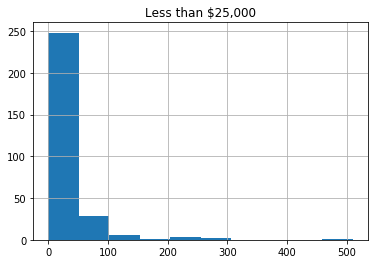

In [46]:
access_incometable.hist('Less than $25,000');

In [36]:
access_incometable.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290 entries, 0 to 289
Data columns (total 10 columns):
LOCATION_N                   290 non-null object
access_by_income_TotalPop    290 non-null float64
Less than $25,000            290 non-null int32
$25,000 to $49,999           290 non-null int32
$50,000 to $74,999           290 non-null int32
$75,000 to $99,999           290 non-null int32
$100,000 to $149,999         290 non-null int32
$150,000 or more             290 non-null int32
Park_Name                    290 non-null object
Total Pop                    290 non-null int32
dtypes: float64(1), int32(7), object(2)
memory usage: 14.9+ KB


In [47]:
access_incometable.describe()

,access_by_income_TotalPop,"Less than $25,000","$25,000 to $49,999","$50,000 to $74,999","$75,000 to $99,999","$100,000 to $149,999","$150,000 or more",Total Pop
count,2.900000e+02,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000
mean,1.719271e+02,29.644828,35.086207,29.568966,20.365517,26.300000,27.993103,171.410345
std,2.398243e+02,47.857864,57.005034,49.045249,33.923344,39.409873,50.796970,239.811981
min,4.018278e-13,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.687323e+01,7.000000,9.000000,9.000000,5.000000,7.000000,5.000000,66.250000
50%,1.037945e+02,15.500000,19.000000,16.500000,11.000000,14.000000,14.000000,103.000000
75%,1.675835e+02,34.000000,39.000000,30.000000,20.000000,26.000000,28.750000,167.250000
max,2.245008e+03,510.000000,601.000000,571.000000,344.000000,303.000000,476.000000,2245.000000


In [42]:
#df.dtype()

### END OF CODE

##### The following are cells of unused code or code that does not work in its current form